# General Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

random_seed = 1

In [2]:
import os

"""
Launch the script to generate the data.
"""
def generate_data(number_blocs_vertical, number_blocs_horizontal):
    number_blocs_vertical = str(number_blocs_vertical)
    number_blocs_horizontal = str(number_blocs_horizontal)
    status = os.system('inst_gen.py -s {} {}'.format(number_blocs_vertical, number_blocs_horizontal))
    if status == 0 : 
        print('SUCCESS : Data generation with ' + number_blocs_vertical + ' by ' + number_blocs_horizontal + ' cities')
        return 'N' + number_blocs_vertical + "_M" + number_blocs_horizontal
    else : 
        print('FAILURE : Data generation with ' + number_blocs_vertical + ' by ' + number_blocs_horizontal + ' cities')
        return ''

"""
Import the data.
"""
def import_data(directory):
    return np.genfromtxt(directory, dtype=np.int64, skip_header=1)

"""
Merge value and costs.
"""
def merge_value_cost(imported_data):
    blocs_data_height = imported_data.shape[0]
    value_data = blocs_data[:int(blocs_data_height/2)]
    cost_data = blocs_data[int(blocs_data_height/2):]
    result_data = value_data - cost_data
    return result_data

# Data Generation

In [3]:
generated_file_name = generate_data(number_blocs_vertical=100, number_blocs_horizontal=100)
blocs_data = import_data(generated_file_name)

SUCCESS : Data generation with 100 by 100 cities


In [4]:
result_data = merge_value_cost(blocs_data)
result_data

array([[ 59,  46,  49, ...,  -3,  85,   6],
       [ 25,  24,  35, ..., -39,  60,  -2],
       [ 43, -41,  23, ...,  14, -20,  45],
       ...,
       [ 35,  41,  42, ...,  -6,  41,  -3],
       [ 44, -12,  24, ...,  49,  40,  -8],
       [ 52,   6,   0, ...,  60, -11,  66]], dtype=int64)

# Developped Algorithm (Algorithme Développé)

## Definitions

In [5]:
def display_solution(holes_list):
    for y in range(holes_list.shape[0]):
        for x in range(holes_list.shape[1]):
            if holes_list[y][x]:
                print(y, x)
    print("")

def remove_hole(y_position, x_position, matrix):
    
    # Bottom left
    try:
        if matrix[y_position + 1][x_position - 1] == True:
            remove_hole(y_position + 1, x_position - 1, matrix)
    except:
        pass
    
    # Bottom
    try:
        if matrix[y_position + 1][x_position    ] == True:
            remove_hole(y_position + 1, x_position, matrix)
    except:
        pass
        
    # Bottom right
    try:
        if matrix[y_position + 1][x_position + 1] == True:
            remove_hole(y_position + 1, x_position + 1, matrix)
    except:
        pass
    
    # Remove hole
    matrix[y_position][x_position] = False
        

In [6]:
def solve(input_data, must_compute_time=True, must_display_path=True, min_row_start_display=200, row_interval_must_display=50):
    
    # Time probe
    if must_compute_time :
        start_time = time.time()
    
    
    # Deep copy the data
    dynamic_data = np.array(input_data)

    # Assignation of the indexes to use
    # 0     X --> X --> X --> X --> LAST  0
    # 0     X --> X --> X --> X --> X     0
    # 0     X --> X --> X --> X --> X     0
    # 0     X --> X --> X --> X --> X     0
    # 0     FIRST X --> X --> X --> X     0
    # 0     0     0     0     0     0     0
    # 0     0     0     0     0     0     0
    data_height = dynamic_data.shape[0]
    data_width = dynamic_data.shape[1]
    
    print(data_height, data_width)
    print(input_data)
    
    lateral_buffer_size = 2
    vertical_buffer_size = 2
    
    hozrizontal_first_index = lateral_buffer_size
    vertical_first_index = dynamic_data.shape[0] - 1

    hozrizontal_last_index = dynamic_data.shape[1] + lateral_buffer_size - 1
    vertical_last_index = 0

    # Add three buffer rows at the bottom
    bottom_buffer = np.zeros((vertical_buffer_size, dynamic_data.shape[1]))
    dynamic_data = np.vstack((dynamic_data, bottom_buffer))
    input_data = np.vstack((input_data, bottom_buffer))

    # Add a buffer column at the left and right side
    latteral_buffer = np.zeros((dynamic_data.shape[0], lateral_buffer_size))
    dynamic_data = np.hstack((latteral_buffer, dynamic_data, latteral_buffer))

    # Compute initial solution
    current_solution = input_data.sum()
    
    # Keep track of hte wholes to make
    holes_list = np.full((data_height, data_width), True, dtype=bool)
    
    # For every row
    has_better_solution_to_display = True
    for index_row in range(vertical_first_index, vertical_last_index - 1, - 1):
        for index_bloc in range(hozrizontal_first_index, hozrizontal_last_index + 1):

            # Hole to inspect
            current_hole = (index_row, index_bloc - lateral_buffer_size)
            
            # Compute the impact of not mining a bloc
            bloc_below = 0
            try:
                bloc_below = input_data[index_row + 1][index_bloc - lateral_buffer_size] * int(holes_list[current_hole[0] + 1][current_hole[1]])
            except:
                pass
            bloc_value = dynamic_data[index_row][index_bloc] + bloc_below + dynamic_data[index_row + 1][index_bloc - 1]  + dynamic_data[index_row + 1][index_bloc + 1] - dynamic_data[index_row + 2][index_bloc]

            # If the bloc has a positive impact on the total value acquired, we assign the value to the dynamix table
            if bloc_value >= 0:
                dynamic_data[index_row][index_bloc] = bloc_value

            # If the bloc has a negative impact on the total value acquired, we do not mine it
            # As a result, we set the value of all the unmined blocs resulting to 0 
            # (only for 2 levels of depth as we will not reuse values that are deeper)
            else:
                
                # Bloc itself
                dynamic_data[index_row][index_bloc] = 0

                # First level of depth
                dynamic_data[index_row + 1][index_bloc] = 0
                dynamic_data[index_row + 1][index_bloc - 1] = 0
                dynamic_data[index_row + 1][index_bloc + 1] = 0

                # Second level of depth
                dynamic_data[index_row + 2][index_bloc - 2] = 0
                dynamic_data[index_row + 2][index_bloc - 1] = 0
                dynamic_data[index_row + 2][index_bloc    ] = 0
                dynamic_data[index_row + 2][index_bloc + 1] = 0
                dynamic_data[index_row + 2][index_bloc + 2] = 0

                # Adjsut the price of the current solution when removing the costly bloc
                current_solution -= bloc_value
                
                # Add the whole to the list of points to remove
                remove_hole(current_hole[0], current_hole[1], holes_list)
                
                # We now have a new better solution
                has_better_solution_to_display = True
                
        if must_display_path and has_better_solution_to_display and (data_height - index_row) >= min_row_start_display and (index_row % row_interval_must_display == 0):
            print("(data_height - index_row)", (data_height - index_row))
            print("min_row_start_display", min_row_start_display)
            print("(data_height - index_row) <= min_row_start_display", (data_height - index_row) <= min_row_start_display)
            print("POSITION ======>", index_row, index_bloc)
            display_solution(holes_list)
            has_better_solution_to_display = False
    
    # Last display
    if must_display_path and has_better_solution_to_display:
        display_solution(holes_list)
        has_better_solution_to_display = False
    
    # Get the best solution
    best_solution = max(current_solution, 0)
    
    # Remove the buffer from the input data
    input_data = input_data[:vertical_buffer_size]

    # RETURN S
    if must_compute_time :
        end_time = time.time()
        computation_time = end_time - start_time
        return (int(best_solution), holes_list, computation_time)
    else :
        return (int(best_solution), holes_list)

In [7]:
solve(result_data, must_compute_time=True, must_display_path=True)

100 100
[[ 59  46  49 ...  -3  85   6]
 [ 25  24  35 ... -39  60  -2]
 [ 43 -41  23 ...  14 -20  45]
 ...
 [ 35  41  42 ...  -6  41  -3]
 [ 44 -12  24 ...  49  40  -8]
 [ 52   6   0 ...  60 -11  66]]
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63


(250372, array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True, False,  True]]), 2.229965925216675)

# Tests

## Definitions

In [169]:
def perform_power_test(x_exp, y_exp, label):
    
    # solve linear system
    x = np.log(x_exp)
    y = np.log(y_exp)
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    y_plot = m * x + c
    
    # Plot data
    plt.figure(figsize=(10,8))
#     plt.xscale("log")
#     plt.yscale("log")
    
    # Experimental data
    plt.plot(np.log(x_exp), np.log(y_exp), color='blue')
    plt.scatter(np.log(x_exp), np.log(y_exp), color='blue', label=label)
    
    # Fit linear
    plt.plot(x, y_plot, color='red', label=str(m) + ' x + ' + str(c))
    

    plt.title("Power Test Representation")
    plt.xlabel("Dataset size (powers of 10)")
    plt.ylabel("Consumption (powers of 10)")
    plt.legend()
    plt.grid()
    plt.show()

In [68]:
def perform_ratio_test(x_exp, y_exp, label, function, function_title='f(x)'):
    
    # Compute ratios
    x = np.array(x_exp)
    y = np.array(y_exp)
    
    function_evaluation = function(x)
    y_plot = y / function_evaluation
    
    # Plot data
    plt.figure(figsize=(10,8))
#     plt.xscale("log", basex=2)
#     plt.yscale("log", basey=2)
    
    # Plot ratio
    plt.plot(x, y_plot, color='red', label='Ratio : {}'.format(function_title))

    plt.title("Ratio Test Representation (" + label + ")")
    plt.xlabel("Dataset size")
    plt.ylabel("Consummation Ratio")
    plt.legend()
    plt.grid()
    plt.show()
    
    return y/(x**2)

In [184]:
def perform_constant_test(x_exp, y_exp, label, function, function_title='f(x)'):
    
    vectorized_function = np.vectorize(function) 
    
    # solve linear system
    x = np.array(x_exp, dtype=np.int64)
    y = np.array(y_exp, dtype=np.int64)
    
    
    x_base_function = vectorized_function(x)
    A = np.vstack([x_base_function, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    
    x_plot = np.linspace(min(x_exp), max(x_exp), 100)
    y_plot = m * vectorized_function(x_plot) + c
    
    # Plot data
    plt.figure(figsize=(10,8))
    plt.xscale("log")
    plt.yscale("log")
    
    # Experimental data
    plt.plot(x_exp, y_exp, color='blue')
    plt.scatter(x_exp, y_exp, color='blue', label=label)
    
    # Fit linear
    plt.plot(x_plot, y_plot, color='red', label=str(m) + ' f(x) + ' + str(c) + ' (' + function_title+ ')')
    

    plt.title("Constant Test Representation")
    plt.xlabel("Dataset size")
    plt.ylabel("Consummation (power of 10)")
    plt.legend()
    plt.grid()
    plt.show()

## Performance calculation for the dynamic programming algorithm

In [180]:
# Data sizes
SIZES_DYNAMIC = list(range(6,21))
dynamic_cities_data_list = []

# Generate files
cities_data_list = []
for size in SIZES_DYNAMIC:
    dynamic_generated_file_name = generate_data(number_cities=size)
    dynamic_cities_data_list.append(import_data(dynamic_generated_file_name))

SUCCESS : Data generation with 6 cities
SUCCESS : Data generation with 7 cities
SUCCESS : Data generation with 8 cities
SUCCESS : Data generation with 9 cities
SUCCESS : Data generation with 10 cities
SUCCESS : Data generation with 11 cities
SUCCESS : Data generation with 12 cities
SUCCESS : Data generation with 13 cities
SUCCESS : Data generation with 14 cities
SUCCESS : Data generation with 15 cities
SUCCESS : Data generation with 16 cities
SUCCESS : Data generation with 17 cities
SUCCESS : Data generation with 18 cities
SUCCESS : Data generation with 19 cities
SUCCESS : Data generation with 20 cities


In [181]:
list_city_count_dynamic = []
list_time_dynamic = []

list_city_count_greedy = []
list_time_greedy = []

list_city_count_approximative = []
list_time_approximative = []

print('Dynamic Programing (DP)')
for data in dynamic_cities_data_list:
    
    solution_dynamic, distance_dynamic, time_dynamic = dynamic_programming_solve(data, must_compute_time=True)
    solution_greedy, distance_greedy, time_greedy = greedy_solve(data, must_compute_time=True)
    solution_approximative, distance_approximative, time_approximative = approximative_solve(data, must_compute_time=True)
    
    list_city_count_dynamic.append(len(data))
    list_time_dynamic.append(time_dynamic)
    
    list_city_count_greedy.append(len(data))
    list_time_greedy.append(time_greedy)
    
    list_city_count_approximative.append(len(data))
    list_time_approximative.append(time_approximative)
 
    print(len(data), time_dynamic, distance_dynamic, time_greedy, distance_greedy, time_approximative, distance_approximative)

Dynamic Programing (DP)
6 0.0049860477447509766 5701 0.0 5727 0.0 7390
7 0.010971307754516602 2956 0.0009970664978027344 3867 0.0009970664978027344 2946
8 0.02892279624938965 4905 0.0 6109 0.0019943714141845703 9233
9 0.5545220375061035 4748 0.0009975433349609375 4983 0.0009965896606445312 8414
10 0.14860081672668457 6982 0.0 6996 0.0009970664978027344 8463
11 0.29421305656433105 6315 0.0 6801 0.0019953250885009766 9450
12 0.5804452896118164 7122 0.0 8193 0.0019943714141845703 10934
13 1.523928165435791 6777 0.0009970664978027344 8870 0.0019948482513427734 15253
14 3.369990825653076 6652 0.0009927749633789062 7447 0.0039899349212646484 13832
15 8.16642451286316 5889 0.0009968280792236328 7069 0.00498652458190918 11634
16 22.29713487625122 7673 0.0009946823120117188 8849 0.005950212478637695 13245
17 51.12832522392273 6691 0.0010006427764892578 7760 0.009006738662719727 10786
18 118.4132490158081 7022 0.000997781753540039 9633 0.007978200912475586 15252
19 271.24541687965393 7725 0.0019

In [210]:
# Funtions
def exponential_comparison_function(x):
    return 1/100000 * x * 2.0851 ** x


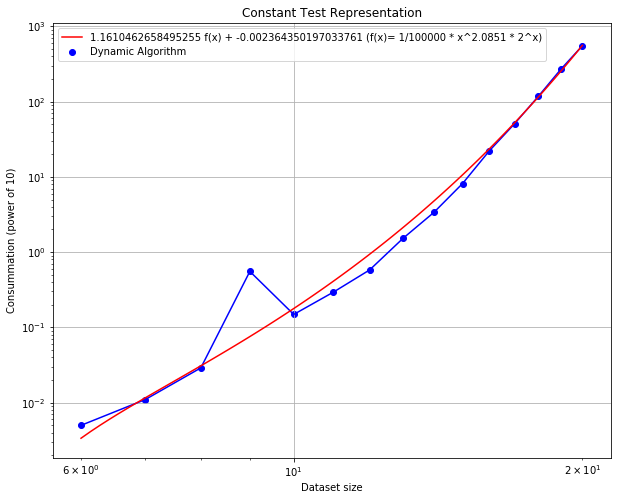

In [212]:
# We have reasons to believe that the function is of the order O(n^2)
perform_constant_test(x_exp=list_city_count_dynamic, 
                      y_exp=list_time_dynamic, 
                      label="Dynamic Algorithm", 
                      function=exponential_comparison_function, 
                      function_title='f(x)= 1/100000 * x^2.0851 * 2^x')

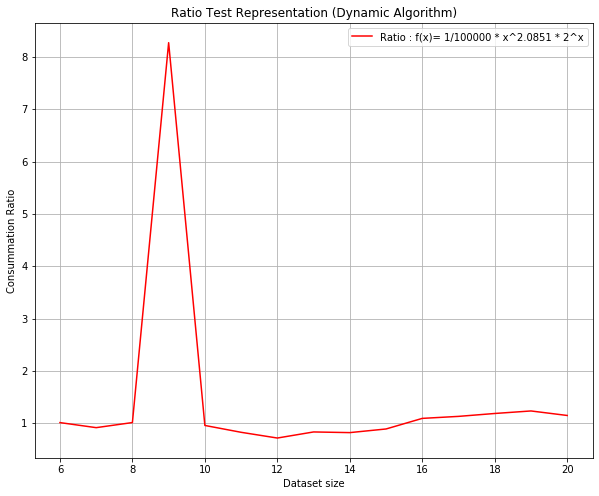

array([1.38501326e-04, 2.23904240e-04, 4.51918691e-04, 6.84595108e-03,
       1.48600817e-03, 2.43151286e-03, 4.03087007e-03, 9.01732642e-03,
       1.71938307e-02, 3.62952201e-02, 8.70981831e-02, 1.76914620e-01,
       3.65472991e-01, 7.51372346e-01, 1.38413357e+00])

In [213]:
perform_ratio_test(x_exp=list_city_count_dynamic, 
                    y_exp=list_time_dynamic, 
                    label="Dynamic Algorithm",
                    function=exponential_comparison_function,
                    function_title='f(x)= 1/100000 * x^2.0851 * 2^x')

## Performance calculation for the approximative and greedy algorithm

In [214]:
# Data sizes
SIZES_APPROXIMATIVE = list(range(20, 410, 20))
approximative_cities_data_list = []

# Generate files
cities_data_list = []
for size in SIZES_APPROXIMATIVE:
    approximative_generated_file_name = generate_data(number_cities=size)
    approximative_cities_data_list.append(import_data(approximative_generated_file_name))

SUCCESS : Data generation with 20 cities
SUCCESS : Data generation with 40 cities
SUCCESS : Data generation with 60 cities
SUCCESS : Data generation with 80 cities
SUCCESS : Data generation with 100 cities
SUCCESS : Data generation with 120 cities
SUCCESS : Data generation with 140 cities
SUCCESS : Data generation with 160 cities
SUCCESS : Data generation with 180 cities
SUCCESS : Data generation with 200 cities
SUCCESS : Data generation with 220 cities
SUCCESS : Data generation with 240 cities
SUCCESS : Data generation with 260 cities
SUCCESS : Data generation with 280 cities
SUCCESS : Data generation with 300 cities
SUCCESS : Data generation with 320 cities
SUCCESS : Data generation with 340 cities
SUCCESS : Data generation with 360 cities
SUCCESS : Data generation with 380 cities
SUCCESS : Data generation with 400 cities


In [215]:
list_city_count_approximative = []
list_time_approximative = []

list_city_count_greedy = []
list_time_greedy = []

print('Approximative (Approx)')
for data in approximative_cities_data_list:
    
    solution_greedy, distance_greedy, time_greedy = greedy_solve(data, must_compute_time=True)
    solution_approximative, distance_approximative, time_approximative = approximative_solve(data, must_compute_time=True)
    
    list_city_count_greedy.append(len(data))
    list_time_greedy.append(time_greedy)
    
    list_city_count_approximative.append(len(data))
    list_time_approximative.append(time_approximative)
 
    print(len(data), time_greedy, distance_greedy, time_approximative, distance_approximative)

Approximative (Approx)
20 0.0039904117584228516 8144 0.02293992042541504 14550
40 0.011970758438110352 11360 0.1406264305114746 35154
60 0.013958454132080078 13852 0.3677077293395996 56721
80 0.02590656280517578 17339 0.7938830852508545 95093
100 0.03290557861328125 19279 1.1888213157653809 105605
120 0.04388546943664551 23786 2.532301187515259 103275
140 0.06780695915222168 21330 3.3999361991882324 155425
160 0.10475707054138184 23512 5.149792671203613 188203
180 0.1077117919921875 25501 7.043384790420532 141161
200 0.15358710289001465 29326 10.615156650543213 211537
220 0.19946599006652832 28539 13.96079158782959 297405
240 0.19747447967529297 32967 19.72634530067444 226339
260 0.30119800567626953 30298 30.200693368911743 267063
280 0.41988706588745117 31174 31.27634072303772 357476
300 0.4537839889526367 32820 38.33677887916565 283916
320 0.4408233165740967 33074 43.72747302055359 405747
340 0.45079708099365234 32207 54.5273711681366 274407
360 0.4607679843902588 36724 64.8505783081

### Greedy algorithm

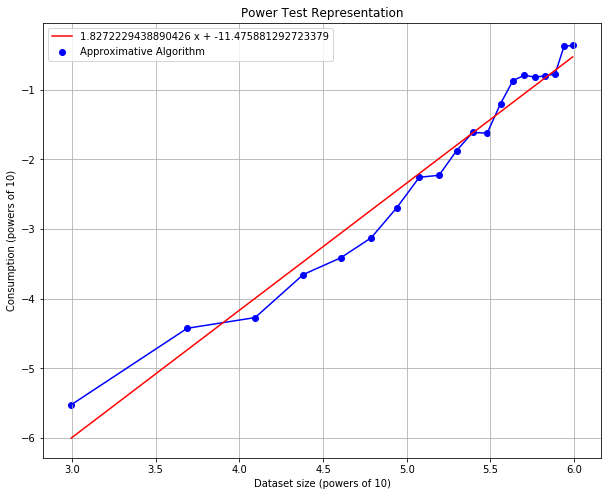

In [216]:
perform_power_test(x_exp=list_city_count_greedy, y_exp=list_time_greedy, label='Approximative Algorithm')   

### Approximative algorithm

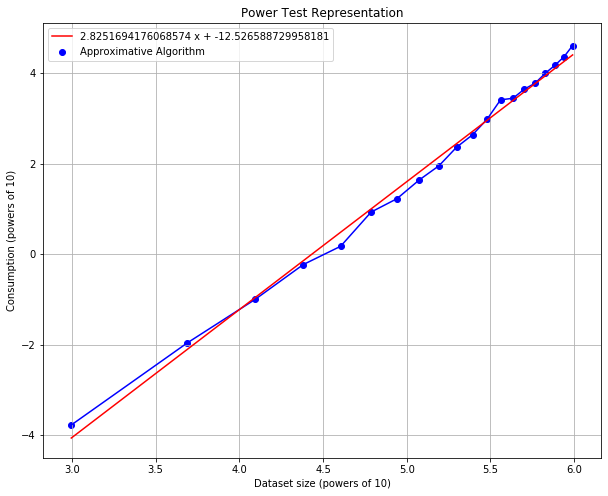

In [217]:
# Approximative algorithm
perform_power_test(x_exp=list_city_count_approximative, y_exp=list_time_approximative, label='Approximative Algorithm')   

## Performance calculation

In [24]:
list_time_greedy = []
list_time_dynamic = []
list_time_approximative = []

print('Greedy (G), Dynamic Programing (DP), Approximative (A)')
for test_data in cities_data_list:
    solution_greedy, distance_greedy, time_greedy = greedy_solve(cities_data, must_compute_time=True)
    solution_dynamic, distance_dynamic, time_dynamic = dynamic_programming_solve(cities_data, must_compute_time=True)
    solution_approximative, distance_approximative, time_approximative = approximative_solve(cities_data, must_compute_time=True)
    
    
    list_time_greedy.append(time_greedy)
    list_time_dynamic.append(time_dynamic)
    list_time_approximative.append(time_approximative)
 
    print('For ', len(test_data), ' city(ies) --> G:', time_greedy, '; DP:', time_dynamic, '; A: ', time_approximative)

Greedy (G), Dynamic Programing (DP), Approximative (A)
For  3  city(ies) --> G: 0.001993894577026367 ; DP: 8.45731782913208 ; A:  0.004985809326171875
For  4  city(ies) --> G: 0.0009980201721191406 ; DP: 8.255603313446045 ; A:  0.005028963088989258
For  5  city(ies) --> G: 0.0 ; DP: 8.319393873214722 ; A:  0.004980325698852539
For  6  city(ies) --> G: 0.0009980201721191406 ; DP: 8.104334831237793 ; A:  0.004987478256225586
For  7  city(ies) --> G: 0.0009975433349609375 ; DP: 8.714564800262451 ; A:  0.0069768428802490234
For  8  city(ies) --> G: 0.0009982585906982422 ; DP: 8.184053659439087 ; A:  0.0059816837310791016
For  9  city(ies) --> G: 0.0 ; DP: 8.558161973953247 ; A:  0.004986286163330078
For  10  city(ies) --> G: 0.0009970664978027344 ; DP: 8.575648784637451 ; A:  0.004986286163330078
For  11  city(ies) --> G: 0.0009975433349609375 ; DP: 8.785784006118774 ; A:  0.0069811344146728516
For  12  city(ies) --> G: 0.001998424530029297 ; DP: 8.557625532150269 ; A:  0.00697827339172363

C:\Users\alexa\.conda\envs\jupiter\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alexa\.conda\envs\jupiter\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  after removing the cwd from sys.path.


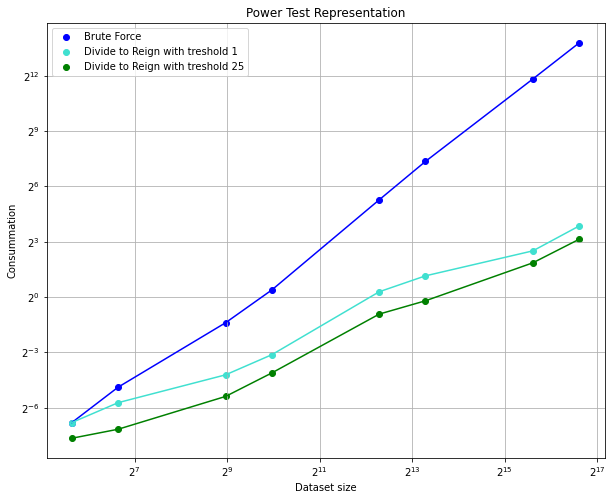

In [120]:
# plt.figure(figsize=(10,8))

# plt.xscale("log", basex=2)
# plt.yscale("log", basey=2)

# # Brute force Algorithm
# plt.plot(SIZES, list_time_brute_force, color='blue')
# plt.scatter(SIZES, list_time_brute_force, color='blue', label='Brute Force')

# # Divide to reign Algorithm with threshold 1
# plt.plot(SIZES, list_time_divide_to_reign_1, color='turquoise')
# plt.scatter(SIZES, list_time_divide_to_reign_1, color='turquoise', label='Divide to Reign with treshold 1')

# # Divide to reign Algorithm with threshold THRESHOLD
# plt.plot(SIZES, list_time_divide_to_reign_2, color='green')
# plt.scatter(SIZES, list_time_divide_to_reign_2, color='green', label='Divide to Reign with treshold '+ str(THRESHOLD))

# plt.title("Power Test Representation")
# plt.xlabel("Dataset size")
# plt.ylabel("Consummation")
# plt.legend()
# plt.grid()
# plt.show()

## Power test

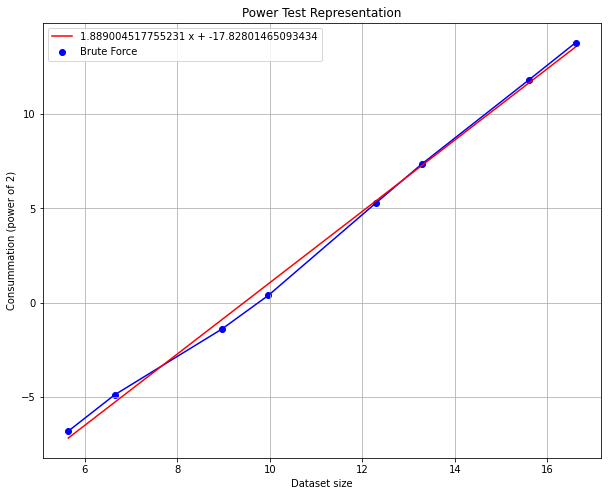

In [116]:
perform_power_test(x_exp=SIZES, y_exp=list_time_brute_force, label='Brute Force')   

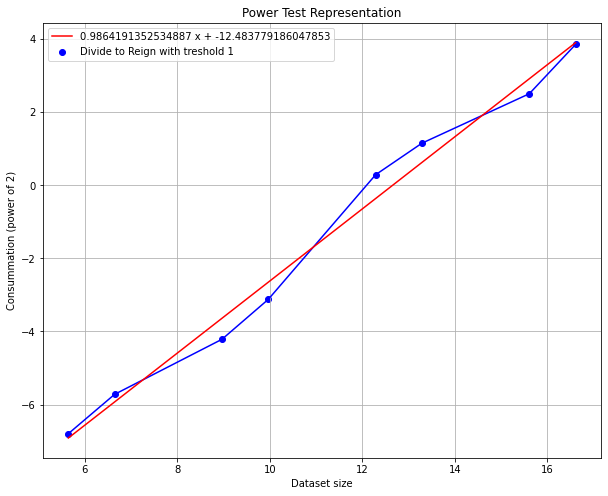

In [117]:
perform_power_test(x_exp=SIZES, y_exp=list_time_divide_to_reign_1, label='Divide to Reign with treshold 1')

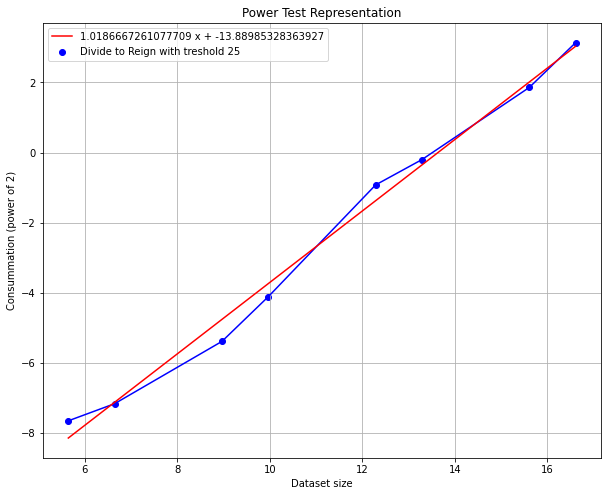

In [118]:
perform_power_test(x_exp=SIZES, y_exp=list_time_divide_to_reign_2, label='Divide to Reign with treshold '+ str(THRESHOLD))

## Ratio Test

C:\Users\alexa\.conda\envs\jupiter\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  del sys.path[0]
C:\Users\alexa\.conda\envs\jupiter\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


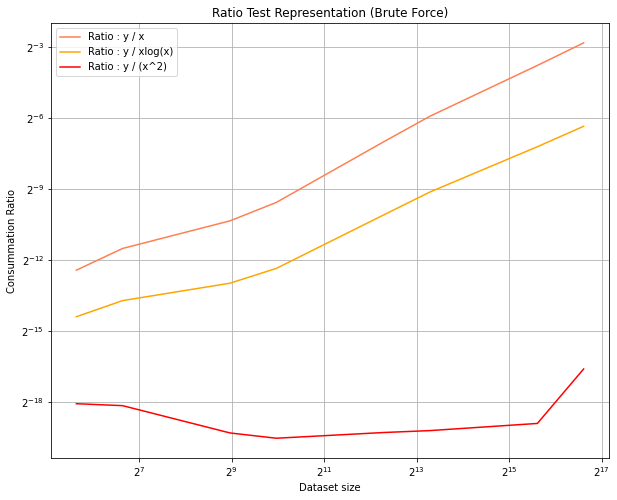

array([ 3.58991623e-06,  3.39107513e-06,  1.52391434e-06,  1.30550575e-06,
        1.54368172e-06,  1.63281273e-06, -2.01346530e-06,  9.92397912e-06])

In [156]:
perform_ratio_test(x_exp=SIZES, y_exp=list_time_brute_force, label="Brute Force")   

C:\Users\alexa\.conda\envs\jupiter\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  del sys.path[0]
C:\Users\alexa\.conda\envs\jupiter\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


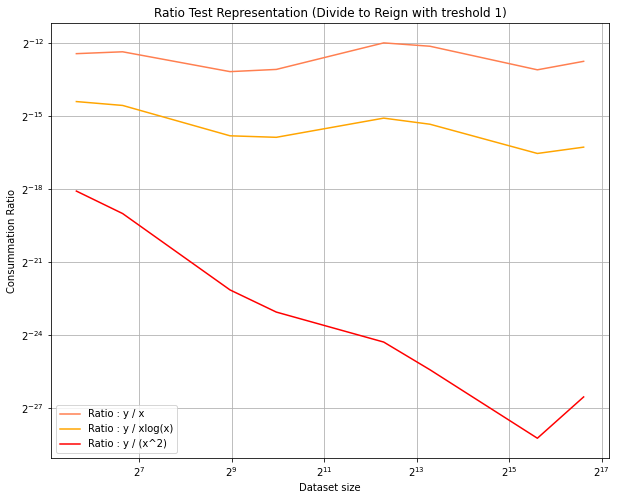

array([ 3.59373093e-06,  1.89468861e-06,  2.15424538e-07,  1.14693403e-07,
        4.88295460e-08,  2.21924067e-08, -3.15985752e-09,  1.02434303e-08])

In [157]:
perform_ratio_test(x_exp=SIZES, y_exp=list_time_divide_to_reign_1, label='Divide to Reign with treshold 1')

C:\Users\alexa\.conda\envs\jupiter\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  del sys.path[0]
C:\Users\alexa\.conda\envs\jupiter\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


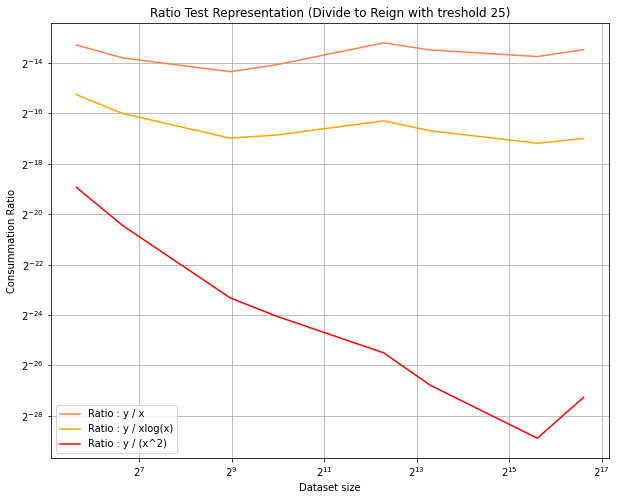

array([ 1.99184418e-06,  6.98256493e-07,  9.57450867e-08,  5.78453541e-08,
        2.11033440e-08,  8.69667530e-09, -2.01746292e-09,  6.21856730e-09])

In [158]:
perform_ratio_test(x_exp=SIZES, y_exp=list_time_divide_to_reign_2, label='Divide to Reign with treshold '+ str(THRESHOLD))

## Constant Test

In [204]:
# Funtions
def power_1(x):
    return x * np.log2(x)

def power_2(x):
    return x**2

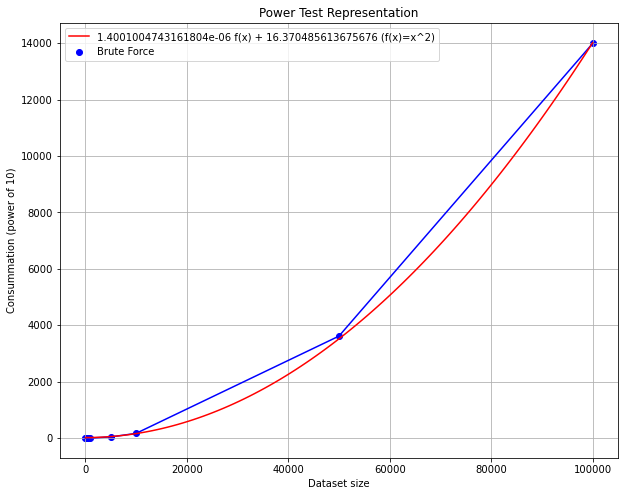

In [205]:
# We have reasons to believe that the function is of the order O(n^2)
perform_constant_test(x_exp=SIZES, y_exp=list_time_brute_force, label="Brute Force", function=power_2, function_title='f(x)=x^2')

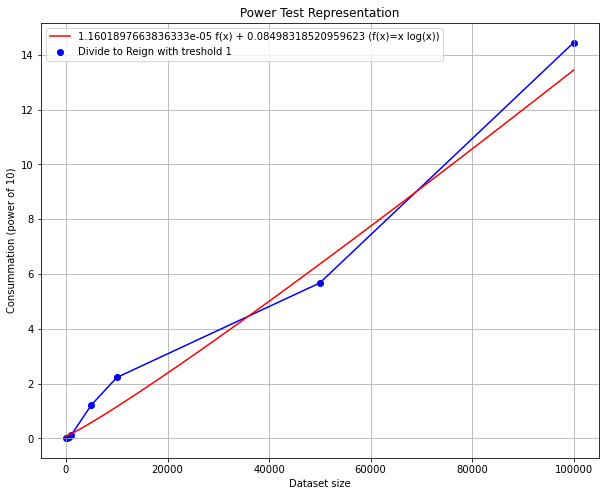

In [206]:
# We have reasons to believe that the function is of the order O(n)
perform_constant_test(x_exp=SIZES, y_exp=list_time_divide_to_reign_1, label='Divide to Reign with treshold 1', function=power_1_log_n, function_title='f(x)=x log(x)')

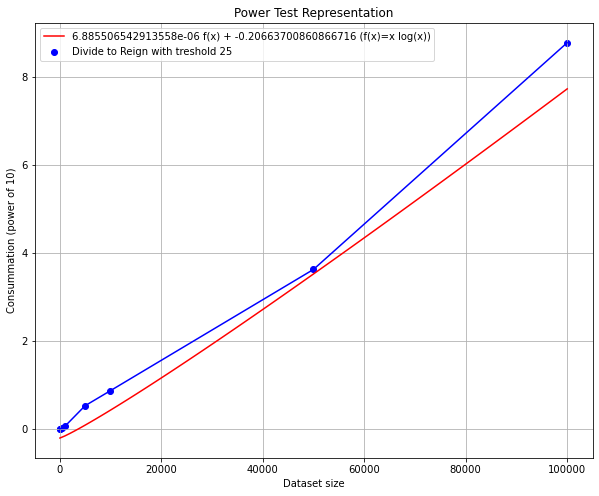

In [207]:
# We have reasons to believe that the function is of the order O(n)
perform_constant_test(x_exp=SIZES, y_exp=list_time_divide_to_reign_2, label='Divide to Reign with treshold '+ str(THRESHOLD), function=power_1_log_n, function_title='f(x)=x log(x)')

# Question 5: Résolution des échantillons difficiles

In [44]:
hard_file_names = ['hard_N52', 'hard_N91', 'hard_N130', 'hard_N169', 'hard_N199']
for file_name in hard_file_names:
    cities_data = import_data(file_name)
    solution_greedy, distance_greedy, time_greedy = greedy_solve(cities_data, must_compute_time=True)
    solution_approximative, distance_approximative, time_approximative = approximative_solve(cities_data, must_compute_time=True)
 
    print('For ', file_name, ' city(ies) --> Distance Greedy:', distance_greedy,'; Distance Approximative: ', distance_approximative)

For  hard_N52  city(ies) --> Distance Greedy: 632300 ; Distance Approximative:  3222705
For  hard_N91  city(ies) --> Distance Greedy: 1338026 ; Distance Approximative:  12533077
For  hard_N130  city(ies) --> Distance Greedy: 2135153 ; Distance Approximative:  26884848
For  hard_N169  city(ies) --> Distance Greedy: 2857273 ; Distance Approximative:  46670663
For  hard_N199  city(ies) --> Distance Greedy: 3352771 ; Distance Approximative:  66289464


# Script to generate python script

In [2]:
!jupyter nbconvert --to script solution_tp2.ipynb

[NbConvertApp] Converting notebook solution_tp2.ipynb to script
[NbConvertApp] Writing 24236 bytes to solution_tp2.py
